# Lab 4 - LDPC Factor Graph Construction

This is the first of the two colab notebooks that form the project.

Here you will construct a **factor graph** for decoding a (regular)
**low-density parity-check (LDPC)** code. Although communication systems often
refer to messages and codewords, in this lab we model only the transmitted bits
$x$ and the channel outputs $y$. All other steps are either preprocessing
(encoding) or postprocessing (reading off the decoded bits).

As the block length $N$ increases, well-designed LDPC codes achieve better decoding performance, while the treewidth of the factor graph grows, making exact inference intractable and motivating approximate methods such as belief propagation.


## Learning goals

- Represent an LDPC code as a **factor graph** with:
  - binary **variable nodes** (bits),
  - **parity-check factors** (XOR constraints),
  - **channel factors** connecting each transmitted bit to its channel output.
- Validate the graph:
  - **structurally**: degrees, factor arities, correct wiring,
  - **semantically**: parity-check factors behave correctly on a known satisfying assignment.

You will be given:
- a generator for a *regular* parity-check matrix $H$ (with configurable density),
- a Binary Symmetric Channel (BSC) noise generator.

You will implement:
1. a parity-check factor constructor,
2. a channel factor constructor,
3. the factor-graph construction from $H$,
4. graph validation checks and visualization,
5. treewidth scaling analysis.

In [ ]:
# Colab setup
!pip -q install pgmpy networkx

In [1]:
import numpy as np
import itertools
import networkx as nx

from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor

/home/rcrtss/.pyenv/versions/miis-2025/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Factor graphs for Low-Density Parity-Check (LDPC) decoding

## Variables and factorization

The task is to transmit $N$ bits over a noisy channel. LDPC codes introduce $M$
parity-check constraints to enable error correction.

The factor graph contains two types of binary variables:
- **transmitted bits**: $x_0,\dots,x_{N-1}$
- **channel outputs**: $y_0,\dots,y_{N-1}$

The joint distribution defined by the factor graph factorizes as
$$
p(x,y)
\;\propto\;
\prod_{m=1}^M \psi_m\bigl(x_{N(m)}\bigr)
\;\;
\prod_{n=0}^{N-1} \phi_n(x_n, y_n),
$$

where $N(m)$ denotes the set of transmitted-bit indices that appear in factor
$\psi_m$, and:
- $\psi_m$ are **parity-check factors** enforcing local constraints on transmitted bits,
- $\phi_n$ are **channel factors** modeling the noise affecting each bit.

## Parity-check factors $\psi_m(x_{N(m)})$

Each parity-check factor enforces an even-parity constraint on a small subset of
transmitted bits.

Formally, the factor is defined as
$$
\psi_m\bigl(x_{N(m)}\bigr)
\;=\;
\begin{cases}
1 & \text{if } \sum_{n \in N(m)} x_n \equiv 0 \pmod 2, \\
0 & \text{otherwise}.
\end{cases}
$$

Thus, each parity-check factor is a **local constraint** that involves only the
$k$ transmitted-bit variables connected to it.

## Channel factors $\phi_n(x_n,y_n)$

Each channel factor connects a transmitted bit $x_n$ to its corresponding channel
output $y_n$.

We model the channel as a **binary symmetric channel (BSC)** with flip probability
$f$, defining
$$
\phi_n(x_n,y_n)
=
p(y_n \mid x_n)
=
\begin{cases}
1-f & \text{if } y_n = x_n, \\
f   & \text{if } y_n \neq x_n.
\end{cases}
$$

Channel factors are independent across bit positions.

## Decoding as inference

In a communication scenario, the channel outputs
$y_0,\dots,y_{N-1}$ are observed.

Decoding consists of inferring the transmitted bits
$x_0,\dots,x_{N-1}$ given these observations, that is, computing the posterior
distribution $p(x \mid y)$.

In the next session, you will approximate this posterior using belief propagation on the same factor graph, after introducing evidence on the $y$ variables.

## Regular LDPC parity-check matrix generator

A **regular LDPC code** is specified by a sparse parity-check matrix $H \in \{0,1\}^{M \times N},$ which defines the structure of the parity-check factors in the factor graph.

- Each row corresponds to one parity-check factor.
- Each column corresponds to one transmitted-bit variable.
- Each row has exactly $k$ ones (each check involves $k$ bits).
- Each column has exactly $j$ ones (each bit participates in $j$ checks).

For a given row $m$, the set
$$
N(m) = \{\, n : H_{m,n} = 1 \,\}
$$
is exactly the set of transmitted bits connected to parity-check factor $\psi_m$.

The following code generates a random **regular LDPC** parity-check matrix:
- each **column** has weight $j$,
- each **row** has weight $k$.

If generation fails (rare for small sizes), re-run the cell or adjust the parameters.

In [2]:
def generate_regular_ldpc_H(N: int, j: int, k: int, seed: int = 0, max_tries: int = 2000) -> np.ndarray:
    """Generate a random (j,k)-regular binary parity-check matrix H of shape (M,N),
    where M = N*j/k must be an integer.

    Notes:
    - This construction is intentionally simple (sufficient for the lab).
    - It may create short cycles; that's fine (Lab 2 is loopy).
    """
    rng = np.random.default_rng(seed)
    if (N * j) % k != 0:
        raise ValueError(f"Need M = N*j/k integer, but N*j={N*j} not divisible by k={k}.")
    M = (N * j) // k

    for _ in range(max_tries):
        # Create j "stubs" per column
        col_stubs = np.repeat(np.arange(N), j)
        rng.shuffle(col_stubs)

        # Assign stubs into M groups of size k (rows)
        H = np.zeros((M, N), dtype=np.uint8)
        ok = True
        for m in range(M):
            cols = col_stubs[m * k : (m + 1) * k]
            # avoid duplicate variable in a single check (keeps row weight exactly k)
            if len(set(cols.tolist())) != k:
                ok = False
                break
            H[m, cols] = 1
        if not ok:
            continue

        # Verify regularity
        if np.all(H.sum(axis=0) == j) and np.all(H.sum(axis=1) == k):
            return H

    raise RuntimeError("Failed to construct a regular LDPC matrix. Try a different seed or parameters.")

## Part 1: Choose code parameters and generate $H$

Pick modest sizes so you can visualize and test easily.
Suggested starting point:
- $N=24$, $j=3$, $k=6$  (then $M=\frac{N j}{k} = 12$)

In [6]:
# TODO: Choose parameters

# 2**(N-M) would be the number of valid codewords, so we want M to be not so large to avoid restricting the code too much. 
# On the other hand, we want M to be large enough to have a non-trivial code (not just the whole space). For example, with N=24, j=3, k=6 gives M=12, so N-M=12 and we have 2^12=4096 codewords, which is a reasonable size for demonstration.

N = 24
j = 3
k = 6
seed_H = 0
M = (N * j) // k
print(f"Generating (j={j}, k={k})-regular LDPC matrix H with N={N} columns and M={M} rows...")

H = generate_regular_ldpc_H(N=N, j=j, k=k, seed=seed_H)
M = H.shape[0]
print(H)

print("H shape:", H.shape)
print("column weights (should all be j):", np.unique(H.sum(axis=0)))
print("row weights (should all be k):", np.unique(H.sum(axis=1)))

Generating (j=3, k=6)-regular LDPC matrix H with N=24 columns and M=12 rows...
[[1 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1]
 [0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 0]
 [0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0]
 [0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0]
 [1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0]]
H shape: (12, 24)
column weights (should all be j): [3]
row weights (should all be k): [6]


## Part 2: Build factors

### 2.1 Parity-check factors $\psi_m(x_{N(m)})$

Implement `make_parity_check_factor` which receives a matrix $H$, a set of variables, and returns a factor defined over the transmitted-bit variables connected to that row.

It should be:
- value = 1 if the parity constraint is satisfied (even parity)
- value = 0 otherwise

Tips:
- With `DiscreteFactor`, you provide a `values` array of length $2^d$ (reshaped to `[2]*d`),
  where `d` is the number of variables in that factor.
- You can generate all assignments with `itertools.product([0,1], repeat=d)`.


Example of a parity-check factor for $k=3$ bits:

$$
\begin{array}{ccc|c}
x_1 & x_2 & x_3 & \psi_{123} \\
\hline
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 1 & 1 & 1 \\
1 & 0 & 0 & 0 \\
1 & 0 & 1 & 1 \\
1 & 1 & 0 & 1 \\
1 & 1 & 1 & 0 \\
\end{array}
$$

In [15]:
def make_parity_check_factor(var_names):
    """Return a DiscreteFactor enforcing even parity over var_names.
    """
    d = len(var_names)
    
    # Generate all possible assignments for the variables
    assignments = list(itertools.product([0, 1], repeat=d))
    
    # Create values array: 1 if even parity (sum is even), 0 otherwise
    values = np.array([1 if sum(assignment) % 2 == 0 else 0 
                       for assignment in assignments], dtype=np.float64)
    
    # Reshape to [2, 2, ..., 2] (d times)
    values = values.reshape([2] * d)
    
    # Create and return the DiscreteFactor
    return DiscreteFactor(var_names, [2] * d, values) # [2]*d means cardinality of 2 (binary) for each of the d (k) variables

# test make_parity_check_factor
factor = make_parity_check_factor(['X1', 'X2', 'X3', 'X4'])
print("Factor variables:", factor.variables)
print("Factor cardinality:", factor.cardinality)
print(factor)

Factor variables: ['X1', 'X2', 'X3', 'X4']
Factor cardinality: [2 2 2 2]
+-------+-------+-------+-------+--------------------+
| X1    | X2    | X3    | X4    |   phi(X1,X2,X3,X4) |
+=======+=======+=======+=======+====================+
| X1(0) | X2(0) | X3(0) | X4(0) |             1.0000 |
+-------+-------+-------+-------+--------------------+
| X1(0) | X2(0) | X3(0) | X4(1) |             0.0000 |
+-------+-------+-------+-------+--------------------+
| X1(0) | X2(0) | X3(1) | X4(0) |             0.0000 |
+-------+-------+-------+-------+--------------------+
| X1(0) | X2(0) | X3(1) | X4(1) |             1.0000 |
+-------+-------+-------+-------+--------------------+
| X1(0) | X2(1) | X3(0) | X4(0) |             0.0000 |
+-------+-------+-------+-------+--------------------+
| X1(0) | X2(1) | X3(0) | X4(1) |             1.0000 |
+-------+-------+-------+-------+--------------------+
| X1(0) | X2(1) | X3(1) | X4(0) |             1.0000 |
+-------+-------+-------+-------+--------------

## Channel factors $\phi_n(x_n,y_n)$

Implement `make_bsc_channel_factor(x_var, y_var, f)`,
a **pairwise factor** over `(x_var, y_var)` defined by a **binary symmetric channel (BSC)** with flip probability $f$.

In [13]:
def make_bsc_channel_factor(x_var, y_var, f):
    """Pairwise channel factor for a BSC.
    Returns a DiscreteFactor over [x_var, y_var] with cardinalities [2,2].
    """
    return DiscreteFactor(
        variables=[x_var, y_var],
        cardinality=[2, 2],
        values=[1 - f, f, f, 1 - f]  # P(y|x): P(y=0|x=0)=1-f, P(y=1|x=0)=f, P(y=0|x=1)=f, P(y=1|x=1)=1-f
    )

# test make_bsc_channel_factor
channel_factor = make_bsc_channel_factor('X', 'Y', f=0.1)
print("Channel factor variables:", channel_factor.variables)
print("Channel factor cardinality:", channel_factor.cardinality)
print(channel_factor)

Channel factor variables: ['X', 'Y']
Channel factor cardinality: [2 2]
+------+------+------------+
| X    | Y    |   phi(X,Y) |
+======+======+============+
| X(0) | Y(0) |     0.9000 |
+------+------+------------+
| X(0) | Y(1) |     0.1000 |
+------+------+------------+
| X(1) | Y(0) |     0.1000 |
+------+------+------------+
| X(1) | Y(1) |     0.9000 |
+------+------+------------+


## Part 3: Create the factor graph from $H$

Construct a `pgmpy` `FactorGraph`:

1. add variable nodes: `x0...x{N-1}`
2. add parity-check factors (one per row of H) and connect them
3. (optional today, required later) add likelihood factors and connect them

Implement:
- `build_ldpc_factor_graph(H, y=None, f=None)`

In [20]:
def build_ldpc_factor_graph(H: np.ndarray, f: float) -> FactorGraph:
    """Build an LDPC factor graph with explicit channel-output variables.

    Variables:
      - transmitted bits: x0..x{N-1}
      - channel outputs:  y0..y{N-1}

    Factors:
      - parity-check factors on x's (from H)
      - channel factors φ_n(x_n, y_n) = p(y_n | x_n) for BSC flip prob f

    Evidence (a particular received word Y) will be introduced later by clamping y's.
    """
    M, N = H.shape
    x_vars = [f"x{n}" for n in range(N)]
    y_vars = [f"y{n}" for n in range(N)]

    G = FactorGraph()

    # 1) Add variable nodes
    G.add_nodes_from(x_vars)
    G.add_nodes_from(y_vars)

    # 2) Add parity-check factors (one per row of H) and connect them
    for m in range(M):
        var_names_row_m = [x_vars[n] for n in range(N) if H[m, n] == 1]
        parity_factor_m = make_parity_check_factor(var_names_row_m)
        G.add_factors(parity_factor_m)
        for var_name in var_names_row_m:
            G.add_edge(parity_factor_m, var_name)

    # 3) Add channel factors φ_n(x_n, y_n) and connect them
    for n in range(N):
        channel_factor_n = make_bsc_channel_factor(x_vars[n], y_vars[n], f)
        G.add_factors(channel_factor_n)
        G.add_edge(channel_factor_n, x_vars[n])
        G.add_edge(channel_factor_n, y_vars[n])

    return G

# test build_ldpc_factor_graph
f = 0.1
G_test = build_ldpc_factor_graph(H, f)
print("Factor graph nodes:", G_test.nodes(data=True))
print("Factor graph edges:", G_test.edges())

Factor graph nodes: [('x0', {'weight': None}), ('x1', {'weight': None}), ('x2', {'weight': None}), ('x3', {'weight': None}), ('x4', {'weight': None}), ('x5', {'weight': None}), ('x6', {'weight': None}), ('x7', {'weight': None}), ('x8', {'weight': None}), ('x9', {'weight': None}), ('x10', {'weight': None}), ('x11', {'weight': None}), ('x12', {'weight': None}), ('x13', {'weight': None}), ('x14', {'weight': None}), ('x15', {'weight': None}), ('x16', {'weight': None}), ('x17', {'weight': None}), ('x18', {'weight': None}), ('x19', {'weight': None}), ('x20', {'weight': None}), ('x21', {'weight': None}), ('x22', {'weight': None}), ('x23', {'weight': None}), ('y0', {'weight': None}), ('y1', {'weight': None}), ('y2', {'weight': None}), ('y3', {'weight': None}), ('y4', {'weight': None}), ('y5', {'weight': None}), ('y6', {'weight': None}), ('y7', {'weight': None}), ('y8', {'weight': None}), ('y9', {'weight': None}), ('y10', {'weight': None}), ('y11', {'weight': None}), ('y12', {'weight': None}), 

## Part 4: Validating the factor graph

We must verify that the factor graph correctly represents the intended LDPC model.

Your task in this part is to **think about validations that make
sense**, and to implement some of them.

Examples of questions you may consider include:
### Structural checks:

- Does the number and type of factors match the specification of the LDPC code?
- Are parity-check factors connected to the correct subsets of transmitted bits?
- Do variable nodes have the expected degrees (for a regular code)?
- Do parity-check factors behave correctly on a known satisfying assignment?
### Semantic checks:
For small $N$, you can test the parity-check factors exhaustively.

For each assignment $x \in \{0,1\}^N$ (there are $2^N$ of them), compute the so-called *syndrome*
$$
s = Hx \pmod 2.
$$
The parity-check constraints are satisfied if and only if $s=0$, so the product of
all parity-check factors should evaluate to
$$
\prod_{m=1}^M \psi_m(x_{N(m)}) =
\begin{cases}
1 & \text{if } Hx \equiv 0 \pmod 2,\\
0 & \text{otherwise.}
\end{cases}
$$

For this semantic test you can ignore the $y$ variables and the channel factors.


In [30]:
def validate_ldpc_graph(G, H):
    """Basic validation of an LDPC factor graph.

    This function performs a minimal sanity check using G.check_code().
    Students are encouraged to extend it with additional structural or
    semantic validations.
    """
    assert G.check_model(), "Basic LDPC graph validation failed."

    # TODO:
    # Add additional checks, for example:
    # - number of variable and factor nodes
    # - degrees of x and y variables
    # - parity-check factor arities
    # - behavior of parity-check factors on a known satisfying assignment
    # ...

    # 1) Check that the model is valid according to pgmpy
    assert G.check_model(), "Factor graph model is not valid."

    # 2) Check that all parity-check factors enforce even parity
    for factor in G.get_factors():
        if factor.scope() and all(var.startswith('x') for var in factor.scope()):
            # This is a parity-check factor
            assert np.all((factor.values == 1) | (factor.values == 0)), "Parity-check factor values must be binary."
            assert np.sum(factor.values) == 2 ** (len(factor.scope()) - 1), "Parity-check factor must have half of its entries as 1's."

    # 3) Check that there there is an equal number of x and y variables, and that they are named correctly
    all_nodes = G.get_variable_nodes()
    N_x = sum(1 for node in all_nodes if node.startswith('x'))
    N_y = sum(1 for node in all_nodes if node.startswith('y')) 
    assert N_x == N_y, f"Expected equal number of x and y variables, but got {N_x} x's and {N_y} y's."

    # 4) Check that degree of each x variable is exactly j and degree of each y variable is 1
    for node in all_nodes:
        degree = G.degree(node)
        if node.startswith('x'):
            assert degree == j+1, f"Expected degree {j} for x variable {node}, but got {degree}."
        elif node.startswith('y'):
            assert degree == 1, f"Expected degree 1 for y variable {node}, but got {degree}."
        else:
            raise ValueError(f"Unexpected variable name {node}. Expected names starting with 'x' or 'y'.")

    return True

N = 24
j = 3
k = 6
seed_H = 0
H = generate_regular_ldpc_H(N=N, j=j, k=k, seed=seed_H)
G_test = build_ldpc_factor_graph(H, f=0.8)
validate_ldpc_graph(G_test, H)


True

## Part 5: Visualization

Implement code that visualizes a factor graph.

You can use `networkx` and `matplotlib.pyplot`, and all the functions from that library such as `nx.draw_networkx_nodes`


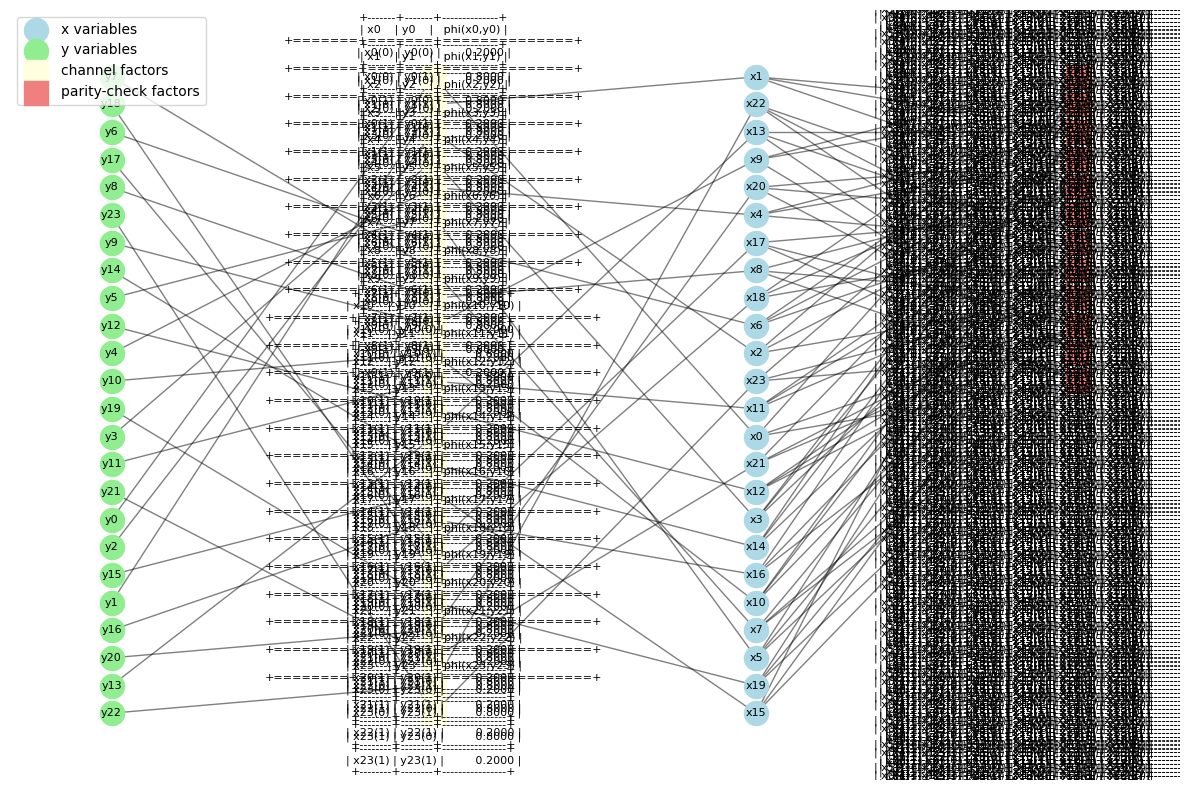

In [31]:
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import FactorGraph

def visualize_factor_graph(G: FactorGraph, max_nodes: int = 200):
    """Visualize an LDPC factor graph with a fixed column layout.

    Columns (left to right):
      y variables → channel factors → x variables → parity-check factors
    """
    Hnx = nx.Graph()

    # TODO:
    # visualize the graph
    # Separate nodes by type
    x_vars = [node for node in G.get_variable_nodes() if node.startswith('x')]
    y_vars = [node for node in G.get_variable_nodes() if node.startswith('y')]
    parity_factors = [f for f in G.get_factors() if all(var.startswith('x') for var in f.scope())]
    channel_factors = [f for f in G.get_factors() if any(var.startswith('y') for var in f.scope())]
    
    # Add all nodes
    Hnx.add_nodes_from(y_vars)
    Hnx.add_nodes_from(channel_factors)
    Hnx.add_nodes_from(x_vars)
    Hnx.add_nodes_from(parity_factors)
    
    # Add edges from the original graph
    for edge in G.edges():
      Hnx.add_edge(*edge)
    
    # Create positions: 4 columns
    pos = {}
    n = len(x_vars)
    col_width = 2
    
    # Column 0: y variables
    for i, var in enumerate(y_vars):
      pos[var] = (0, -i)
    
    # Column 1: channel factors
    for i, factor in enumerate(channel_factors):
      pos[factor] = (col_width, -i)
    
    # Column 2: x variables
    for i, var in enumerate(x_vars):
      pos[var] = (2*col_width, -i)
    
    # Column 3: parity-check factors
    for i, factor in enumerate(parity_factors):
      pos[factor] = (3*col_width, -i)
    
    # Draw the graph
    fig, ax = plt.subplots(figsize=(12, max(8, n/3)))
    
    # Draw nodes
    nx.draw_networkx_nodes(Hnx, pos, nodelist=x_vars, node_color='lightblue', 
                 node_size=300, label='x variables', ax=ax)
    nx.draw_networkx_nodes(Hnx, pos, nodelist=y_vars, node_color='lightgreen', 
                 node_size=300, label='y variables', ax=ax)
    nx.draw_networkx_nodes(Hnx, pos, nodelist=channel_factors, node_color='lightyellow', 
                 node_shape='s', node_size=300, label='channel factors', ax=ax)
    nx.draw_networkx_nodes(Hnx, pos, nodelist=parity_factors, node_color='lightcoral', 
                 node_shape='s', node_size=300, label='parity-check factors', ax=ax)
    
    # Draw edges and labels
    nx.draw_networkx_edges(Hnx, pos, ax=ax, alpha=0.5)
    nx.draw_networkx_labels(Hnx, pos, font_size=8, ax=ax)
    
    ax.legend(loc='upper left')
    ax.axis('off')
    plt.tight_layout()
    plt.show()


H = generate_regular_ldpc_H(N=24, j=3, k=6, seed=1)
G_test = build_ldpc_factor_graph(H, f=0.8)
visualize_factor_graph(G_test)


## Part 6: Treewidth scaling with block length $N$

To study how inference complexity scales with the block length $N$, we analyze the **treewidth** of the LDPC code.

We first construct the **primal graph** on the transmitted bits $x_0,\dots,x_{N-1}$: this is an undirected graph in which two bits are connected by an edge if they appear together in any parity-check factor. It is analogous to moralization, but applied to a factor graph rather than a Bayesian network.

Since computing treewidth exactly is NP-hard, we estimate it using a
**min-fill heuristic**, which provides an upper bound on the treewidth.

Use `networkx.algorithms.approximation.treewidth_min_fill_in` to estimate the
treewidth of the primal graph for increasing values of $N$, and plot the result. When do you think inference will start being intractable?

In [ ]:
from networkx.algorithms.approximation import treewidth_min_fill_in

def ldpc_primal_graph_on_x(G):
    """Build the primal graph on x-variables only.

    Nodes: x0..x{N-1}
    Edge between xi and xj if some parity-check factor contains both.
    """
    # TODO:
    # - create an undirected NetworkX graph
    # - add one node per x-variable
    # - for each parity-check factor, connect all x-variables that appear together
    raise NotImplementedError


def treewidth_scaling_experiment(N_list, j, k, f=0.08, seed0=0):
    """Estimate treewidth scaling for increasing block lengths N.

    Returns a list of tuples (N, estimated_treewidth, num_edges).
    """
    # TODO:
    # - for each N:
    #   - generate a regular LDPC parity-check matrix H
    #   - build the LDPC factor graph
    #   - construct the primal graph on x-variables
    #   - estimate treewidth using networkx.treewidth_min_fill_in
    # - return the collected results
    raise NotImplementedError

N_list = [12, 18, 24, 30, 36, 42, 50]
j, k = 3, 6
tw_results = treewidth_scaling_experiment(N_list, j=j, k=k, f=0.08, seed0=0)
tw_results